# Subject data to catatonia prediction 
Data includes: 
    - Bush-Francis pre/post treatment
    - Drugs and doses pre/post treatment for antipsychotic, lamotragine and benzos
* Drug doses are used to calculate target concentration and target occupation.
* Target occupations are coupled to Wilson-Cowan model parameters. 
* Model parameters are optimized for catatonia symptoms.

In [1]:
%matplotlib inline
from IPython.display import display   # To print DataFrames nicely
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sys
root_path = '/home/ec2-user/SageMaker/cascadia-behavioral-healthcare'
sys.path.insert(1, root_path + '/src')
data_path = root_path + '/data' # location of data files

### Transform target occupations to Wilson_Cowan model parameters
Wilson-Cowan description of cortical states generated by excitatory-inhibitory neural pools.
Population of excitatory and inhibitory neurons:
$$\tau_0 \dot{u_0} = -u_0 + f(w_{00}u_0 + w_{01}u_1 + I_0)$$
$$\tau_1 \dot{u_1} = -u_1 + f(w_{10}u_0 + w_{11}u_1 + I_1)$$
where for the E-I circuit, $w_{00}<0$ and $w_{01}<0$.

### Define class to convert clinical dose data to Wilson-Cowan model parameters

In [2]:
import neural_mech.conc_effect as ce     # Custom code for calculating PK effects
# d2m = ce.Dose_Conversion(clinical_data)

# Load clinical data and seperate into pre/post-treatment datasets
data_file_name = 'synth_drug_BF__07212022.csv'
# pre_clinical, post_clinical = ce.seperate_clinical_pre_post(pd.read_csv(data_path + '/' 
#                                                                      + data_file_name))
pre_clinical, post_clinical = ce.seperate_clinical_pre_post(pd.read_csv(data_file_name))

# Instantiate data processing objects for pre & post data
d2a_pre = ce.Dose_Conversion(pre_clinical)
d2a_post = ce.Dose_Conversion(post_clinical)

# Load pharmacokinetic information on relevant drugs
drugParams = pd.read_excel(data_path + '/' + 'drugParams.xls', sheet_name='params')
d2a_pre.load_pharmacokinetic_info(drugParams)
d2a_post.load_pharmacokinetic_info(drugParams)

# Load drug affinity data and calculate target occupancy
pdspDataFile = 'kidb110121.txt'
kidb110121 = pd.read_csv(data_path + '/' + pdspDataFile, 
                                header=None, sep="\t", error_bad_lines=False, 
                                engine='python')
d2a_pre.load_drug_affinities(kidb110121)
d2a_post.load_drug_affinities(kidb110121)

In [3]:
# Calculate Wilson-Cowan parameter values corresponding to doses
model_param_pre = d2a_pre.dose_to_model(p_wt=0.35)
display(model_param_pre.head())

model_param_post = d2a_post.dose_to_model(p_wt=0.35)
display(model_param_post.head())

,mu0,mu1,th0,th1,w00,w01,w10,w11
0,1.0,0.997992,1.001722,1.002889,1.019348,1.021429,0.998278,1.001972
1,1.0,0.998242,1.001132,1.002188,1.000000,1.001740,0.998868,1.001740
2,1.0,0.999654,1.000038,1.000853,1.000000,1.000346,0.999962,1.000346
3,1.0,0.999134,1.000713,1.002161,1.000000,1.000860,0.999287,1.000860
4,1.0,0.998764,1.000058,1.000886,1.000000,1.001236,0.999942,1.001236


,mu0,mu1,th0,th1,w00,w01,w10,w11
0,1.0,0.998449,1.000471,1.036300,1.025330,1.026988,0.994959,0.996950
1,1.0,0.998909,1.000330,1.029218,1.019348,1.020496,0.995555,0.996957
2,1.0,0.998907,1.000334,1.029922,1.022366,1.023526,0.995095,0.996500
3,1.0,0.999485,1.000165,1.017890,1.006696,1.007221,0.996176,0.996849
4,1.0,0.998459,1.000207,1.010028,1.011552,1.013142,0.995677,0.997402


Combine the ON/OFF Bush-Francis Total score with the model parameters

In [4]:
model_param_pre['BF_total'] =  pre_clinical['pre_total_bf'] 
model_param_post['BF_total'] =  post_clinical['post_total_bf'] 
model_param_pre.loc['control','BF_total'] = 0
model_param_post.loc['control','BF_total'] = 0

print (len(model_param_pre), len(model_param_post))
display(model_param_pre.tail())
display(model_param_post.tail())

param_BF = model_param_pre.append(model_param_post)
print(param_BF.tail(1).index)
param_BF.drop(param_BF.tail(1).index, inplace=True)
param_BF.reset_index(drop=True, inplace=True)
print (len(param_BF))
param_BF.tail()

59 59


,mu0,mu1,th0,th1,w00,w01,w10,w11,BF_total
54,1.0,0.999384,1.000885,1.001558,1.0,1.000609,0.999115,1.000609,17.0
55,1.0,0.998945,1.001127,1.002651,1.0,1.001041,0.998873,1.001041,16.0
56,1.0,0.998945,1.001127,1.002651,1.0,1.001041,0.998873,1.001041,11.0
57,1.0,0.999654,1.000038,1.000853,1.0,1.000346,0.999962,1.000346,20.0
control,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,0.0


,mu0,mu1,th0,th1,w00,w01,w10,w11,BF_total
54,1.0,0.999483,1.000168,1.018578,1.009949,1.010480,0.995716,0.996392,3.0
55,1.0,0.998459,1.000206,1.010692,1.011552,1.013142,0.995220,0.996943,5.0
56,1.0,0.999291,1.000108,1.007947,1.011552,1.012285,0.995775,0.996582,0.0
57,1.0,0.998461,1.000203,1.010023,1.009949,1.011530,0.995681,0.997401,4.0
control,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


Index(['control'], dtype='object')
116


,mu0,mu1,th0,th1,w00,w01,w10,w11,BF_total
111,1.0,0.999292,1.000105,1.007280,1.044520,1.045318,0.996235,0.997039,0.0
112,1.0,0.999483,1.000168,1.018578,1.009949,1.010480,0.995716,0.996392,3.0
113,1.0,0.998459,1.000206,1.010692,1.011552,1.013142,0.995220,0.996943,5.0
114,1.0,0.999291,1.000108,1.007947,1.011552,1.012285,0.995775,0.996582,0.0
115,1.0,0.998461,1.000203,1.010023,1.009949,1.011530,0.995681,0.997401,4.0


### Load the neural model generator
Define a function to set the model parameters and compute the fixed points.

In [5]:
# param_BF

In [6]:
import neural_mech.neural_circuit as ncircuit
nc = ncircuit.Neural_Circuit()

# Calculate the boundary for the devault parameters.
model_pars = ['mu0','mu1','th0','th1','w00', 'w01','w10','w11']
pars = nc.default_pars()
boundary, i_nullcline = nc.calc_barrier(pars, verbose=True)
# i_nullcline

1.7696743875687586
[0. 0.] [0.46825292 0.31107848] [0.87787431 0.7126971 ]


In [7]:
# # Find representative parameters using the subject with BF score closest to the mean
# num_subj = int(len(param_BF)/2)
# mean_pre_bf = np.mean(param_BF.head(num_subj)['BF_total'])
# mean_post_bf = np.mean(param_BF.tail(num_subj)['BF_total'])
# print(mean_pre_bf, mean_post_bf)

# min_dist = 100
# best_subject_idx = [0,num_subj]
# for idx, row in param_BF.head(num_subj).iterrows():
#     pre_bf = row['BF_total']
#     post_bf = param_BF.loc[idx+num_subj, 'BF_total']
#     dist = (mean_pre_bf-pre_bf)**2 + (mean_post_bf-post_bf)**2
#     if dist<min_dist:
#         best_subject_idx = [idx, num_subj+idx]
        
# best_subject_idx

In [8]:
# Calculate the pre & post barriers for the subject closest to the mean BF

def idx_to_barrier(idx, param_BF):
    pars = nc.default_pars()
    subject_pars = param_BF.loc[idx]
    for p in model_pars:
        pars[p] = pars[p]*subject_pars[p]
    barrier, i_nullcline = nc.calc_barrier(pars, verbose=False)
    return barrier

subj_barrier = idx_to_barrier(0, param_BF)
subj_barrier

1.5604561260980891

In [9]:
# convert BF to barrier
def bf_barrier(bf, pre_bf, post_bf, pre_barrier, post_barrier):
    slope = (post_barrier-pre_barrier)/(post_bf-pre_bf)
    intercept = post_barrier - slope*post_bf
    return slope*bf + intercept

# # test_bf = np.mean(param_BF.tail(num_subj)['BF_total'])
# test_bf = np.mean(param_BF.head(num_subj)['BF_total'])
# bf_pred_barrier = bf_barrier(test_bf, mean_pre_bf, mean_post_bf, 
#                              mean_pre_barrier, mean_post_barrier)
# print('mean', test_bf, bf_pred_barrier)

# test_bf = np.min(param_BF.head(num_subj)['BF_total'])
# bf_pred_barrier = bf_barrier(test_bf, mean_pre_bf, mean_post_bf, 
#                              mean_pre_barrier, mean_post_barrier)
# print('min', test_bf, bf_pred_barrier)

# test_bf = np.max(param_BF.head(num_subj)['BF_total'])
# bf_pred_barrier = bf_barrier(test_bf, mean_pre_bf, mean_post_bf, 
#                              mean_pre_barrier, mean_post_barrier)
# print('max', test_bf, bf_pred_barrier)

test_bf = 9
bf_pred_barrier = bf_barrier(test_bf, 20, 0, 1.8, 0.8)
print('20:1', test_bf, bf_pred_barrier)

20:1 9 1.25


Barrier range: 0.7067917122325366 2.9677741307696985 2.260982418537162


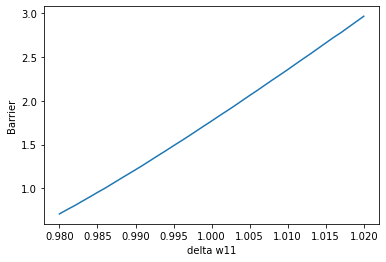

In [10]:
# find effect of changes in w11 on the barrier
barriers = []
delta_w = np.arange(0.98, 1.02, 0.001)
for d in delta_w:
    pars = nc.default_pars()
    pars['w11'] = pars['w11']*d
    barrier, i_nullcline = nc.calc_barrier(pars, verbose=False)
    barriers.append(barrier)
#     print(d, barrier)
print('Barrier range:', barriers[0], barriers[-1], barriers[-1]-barriers[0])
plt.plot(delta_w, barriers)
plt.xlabel('delta w11')
plt.ylabel('Barrier');

Barrier range: 1.5151598058501556 2.0141129259854784 0.4989531201353228


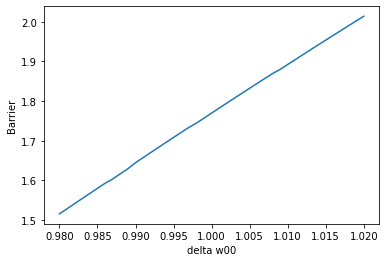

In [11]:
# find effect of changes in w00 on the barrier
barriers = []
delta_w = np.arange(0.98, 1.02, 0.001)
for d in delta_w:
    pars = nc.default_pars()
    pars['w00'] = pars['w00']*d
    barrier, i_nullcline = nc.calc_barrier(pars, verbose=False)
    barriers.append(barrier)
#     print(d, barrier)
print('Barrier range:', barriers[0], barriers[-1], barriers[-1]-barriers[0])
plt.plot(delta_w, barriers)
plt.xlabel('delta w00')
plt.ylabel('Barrier');

Barrier range: 2.259082462982638 1.2832281067223557 -0.9758543562602822


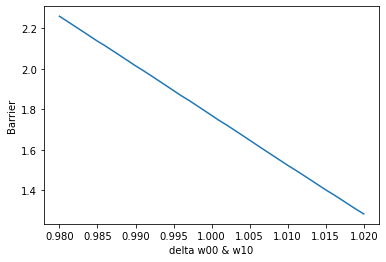

In [12]:
# find effect of changes in w01 on the barrier
barriers = []
delta_w = np.arange(0.98, 1.02, 0.001)
for d in delta_w:
    pars = nc.default_pars()
#     pars['w00'] = pars['w00']*d
    pars['w01'] = pars['w01']*d
    barrier, i_nullcline = nc.calc_barrier(pars, verbose=False)
    barriers.append(barrier)
#     print(d, barrier)
print('Barrier range:', barriers[0], barriers[-1], barriers[-1]-barriers[0])
plt.plot(delta_w, barriers)
plt.xlabel('delta w00 & w10')
plt.ylabel('Barrier');

In [13]:
def find_nearest_delta_w(value, barriers, delta_w):
    barriers = np.asarray(barriers)
    idx = (np.abs(barriers - value)).argmin()
    return delta_w[idx]

find_nearest_delta_w(bf_pred_barrier, barriers, delta_w)

1.02

In [14]:
# Calculate the difference between the initial barrier and the predicted from BF
num_subj = int(len(param_BF)/2)
personal_factor_w = []
for subject_idx in range(num_subj):
    par_barrier = idx_to_barrier(subject_idx, param_BF)
    bf_pred_barrier = bf_barrier(param_BF.loc[subject_idx, 'BF_total'], 20, 0, 1.8, 0.8)
#     print(par_barrier, bf_pred_barrier)
    bf_pred_delta_w = find_nearest_delta_w(bf_pred_barrier, barriers, delta_w)
    par_barrier_delta_w = find_nearest_delta_w(par_barrier, barriers, delta_w)
    personal_factor_w.append(bf_pred_delta_w/par_barrier_delta_w)

In [15]:
# Personalize the parameters
param_BF.loc[:num_subj-1, 'w01'] = personal_factor_w*param_BF.loc[:num_subj-1, 'w01']
param_BF.loc[num_subj:, 'w01'] = personal_factor_w*param_BF.loc[num_subj:, 'w01']
param_BF

,mu0,mu1,th0,th1,w00,w01,w10,w11,BF_total
0,1.0,0.997992,1.001722,1.002889,1.019348,1.016362,0.998278,1.001972,18.0
1,1.0,0.998242,1.001132,1.002188,1.000000,1.013773,0.998868,1.001740,14.0
2,1.0,0.999654,1.000038,1.000853,1.000000,1.006342,0.999962,1.000346,16.0
3,1.0,0.999134,1.000713,1.002161,1.000000,0.994860,0.999287,1.000860,22.0
4,1.0,0.998764,1.000058,1.000886,1.000000,1.012250,0.999942,1.001236,14.0
...,...,...,...,...,...,...,...,...,...
111,1.0,0.999292,1.000105,1.007280,1.044520,1.060997,0.996235,0.997039,0.0
112,1.0,0.999483,1.000168,1.018578,1.009949,1.015533,0.995716,0.996392,3.0
113,1.0,0.998459,1.000206,1.010692,1.011552,1.020234,0.995220,0.996943,5.0
114,1.0,0.999291,1.000108,1.007947,1.011552,1.029494,0.995775,0.996582,0.0


In [16]:
# param_BF.tail(40)

0 1.681306558431998
1 1.4927107983250871
2 1.6093604830434933
3 1.9038898881412618
4 1.5046482390048161
5 1.736556572212445
6 1.6102666632033384
7 1.9314572794104643
8 1.3738965860274162
9 1.4076144004694653
10 1.689478591167053
11 1.8441691439941685
12 1.7105288622719952
13 1.7091647386038067
14 1.7339718418181949
15 1.9178194890988725
16 1.4964562845836746
17 1.756817992901594
18 1.4887781080656963
19 1.8320547232501911
20 1.7521369712940598
21 1.8565721711640877
22 1.736556572212445
23 1.704200953401592
24 1.414613119243913
25 1.7439040174086715
26 1.4436587834123424
27 1.8938090267671863
28 1.5468738999631622
29 2.091221610148193
30 1.4505456917099617
31 1.641457435052406
32 2.0734727909962185
33 1.4984377296538396
34 1.5030192964937905
35 1.9519693076455154
36 1.597688533238037
37 1.84418891782289
38 1.6891798027902587
39 1.5376789306178311
40 1.6447098665548734
41 1.4604046066994574
42 1.414613119243913
43 2.1012479266633113
44 1.4040907814748642
45 1.7865624413520305
46 1.510472

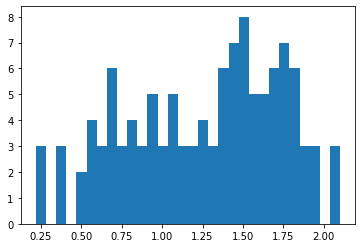

In [17]:
params_df = param_BF[['mu0','mu1','th0','th1','w00','w01','w10','w11']].reset_index(drop=True)
barriers = []
for index, row in params_df.iterrows():
    pars = nc.default_pars()
    subject_pars = row
    for p in model_pars:
        pars[p] = pars[p]*subject_pars[p]
#     print(index, wc.find_fp(pars, 0, 0), wc.find_fp(pars, 0.4, 0.5), wc.find_fp(pars, 1, 0.9))
    barrier, i_nullcline = nc.calc_barrier(pars, verbose=False)
    barriers.append(barrier)
    print(index, barrier)

plt.hist(barriers, bins=30);


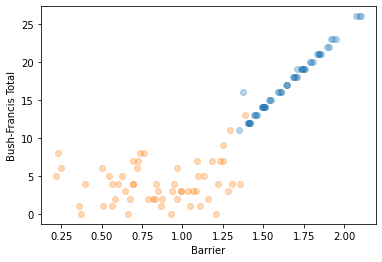

In [18]:
num_subj = int(len(barriers)/2)
plt.plot(barriers[:num_subj], param_BF.head(num_subj)['BF_total'], 'o', alpha=0.3)
plt.plot(barriers[num_subj:], param_BF.tail(num_subj)['BF_total'], 'o', alpha=0.3)
plt.xlabel('Barrier')
plt.ylabel('Bush-Francis Total');

In [19]:
# print('Mean pre-barrier', np.mean(barriers[:num_subj]))
# print('Mean pre-BF', np.mean(param_BF.head(num_subj)['BF_total']))
# print('Mean post-barrier', np.mean(barriers[num_subj:]))
# print('Mean post-BF', np.mean(param_BF.tail(num_subj)['BF_total']))
# plt.plot([np.mean(param_BF.tail(num_subj)['BF_total']),
#           np.mean(param_BF.head(num_subj)['BF_total'])],
#         [np.mean(barriers[num_subj:]),np.mean(barriers[:num_subj])])
# plt.xlabel('BF')
# plt.ylabel('barrier');

13.745689419870855 -6.593341354994957 0.8797689647802338


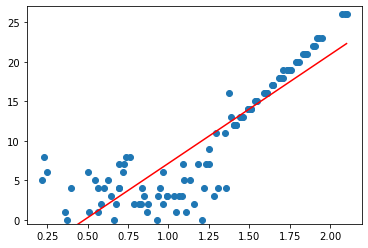

In [20]:
from scipy import stats

# Test linear fit for barrier-BF
x = barriers
y = param_BF['BF_total']
gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print(gradient, intercept, r_value)
mn=np.min(x)
mx=np.max(x)
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
plt.plot(x,y,'o')
plt.plot(x1,y1,'-r')
plt.ylim(-0.5,27);

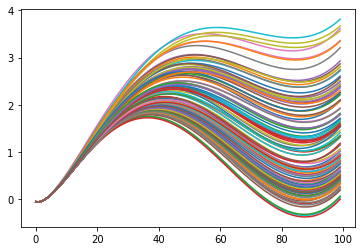

In [21]:
# nc.plot_potential(nc.default_pars(), print_fp=True)

plt.figure()
for index, row in params_df.iterrows():
    pars = nc.default_pars()
    subject_pars = row
    for p in model_pars:
        pars[p] = pars[p]*subject_pars[p]
#     print(index, nc.find_fp(pars, 0, 0), nc.find_fp(pars, 0.4, 0.5), nc.find_fp(pars, 1, 0.9))
    nc.plot_potential(pars)

### Personalize treatment response

In [22]:
model_param_pre = d2a_pre.dose_to_model(p_wt=0.35)[:-1]
model_param_pre.loc[:, 'w01'] = personal_factor_w*model_param_pre.loc[:, 'w01']

In [23]:
def subj_2_barrier(subj, model_param):
    pars = nc.default_pars()
    subject_pars = model_param.loc[subj]
    for p in model_pars:
        pars[p] = pars[p]*subject_pars[p]
    barrier, i_nullcline = nc.calc_barrier(pars, verbose=False)
    return barrier

subj_num = []
p_wts = []
pre_barriers = []
post_barriers = []
pre_bf = []
post_bf = []
change_bfs = []
target_barriers = []
# for subj in [1, 32, 45]:
for subj in pre_clinical.index:
    for pw in np.arange(0.1, 1.05, 0.05):
        model_param_pre = d2a_pre.dose_to_model(p_wt=pw)[:-1]
        model_param_pre.loc[:, 'w01'] = personal_factor_w*model_param_pre.loc[:, 'w01']  # personalize pre_BF with w01
        model_param_post = d2a_post.dose_to_model(p_wt=pw)[:-1]
        model_param_post.loc[:, 'w01'] = personal_factor_w*model_param_post.loc[:, 'w01']  # personalize pre_BF with w01
        change_bf = pre_clinical.loc[subj, 'pre_total_bf'] - post_clinical.loc[subj, 'post_total_bf']
        barrier_pre = subj_2_barrier(subj, model_param_pre)
        barrier_post = subj_2_barrier(subj, model_param_post)
        change_barier = barrier_pre - barrier_post
        if change_barier>change_bf/20:
            subj_num.append(subj)
            p_wts.append(pw)
            pre_barriers.append(barrier_pre)
            post_barriers.append(barrier_post)
            pre_bf.append(pre_clinical.loc[subj, 'pre_total_bf'])
            post_bf.append(post_clinical.loc[subj, 'post_total_bf'])
            change_bfs.append(change_bf)
            target_barriers.append(change_bf/20)
            break
        if pw>=1.:
            subj_num.append(subj)
            p_wts.append(pw)
            pre_barriers.append(barrier_pre)
            post_barriers.append(barrier_post)
            pre_bf.append(pre_clinical.loc[subj, 'pre_total_bf'])
            post_bf.append(post_clinical.loc[subj, 'post_total_bf'])
            change_bfs.append(change_bf)
            target_barriers.append(change_bf/20)
    print(subj, pw, change_bf, change_bf/20, change_barier)

0 0.25000000000000006 12 0.6 0.7215423474251523
1 0.20000000000000004 10 0.5 0.5646476073653186
2 0.20000000000000004 11 0.55 0.5945763068570935
3 0.5500000000000002 18 0.9 0.9069200922632157
4 0.45000000000000007 11 0.55 0.5971581924388335
5 0.20000000000000004 11 0.55 0.600948611015999
6 0.20000000000000004 11 0.55 0.6486735860164108
7 0.30000000000000004 22 1.1 1.202290673670973
8 0.25000000000000006 15 0.75 0.8005161358391049
9 0.25000000000000006 10 0.5 0.5361068399870935
10 0.15000000000000002 10 0.5 0.7228039920786505
11 0.3500000000000001 10 0.5 0.5474482908953748
12 0.3500000000000001 15 0.75 0.7632251092254407
13 0.25000000000000006 16 0.8 0.8429253593574002
14 0.30000000000000004 13 0.65 0.6670661522228136
15 0.40000000000000013 16 0.8 0.828510286429639
16 0.25000000000000006 11 0.55 0.6303067795693152
17 0.20000000000000004 12 0.6 0.6407940529903728
18 0.45000000000000007 12 0.6 0.6445088859263395
19 0.20000000000000004 15 0.75 0.8370877238235228
20 0.25000000000000006 15 0

In [24]:
personalized_boundary = pd.DataFrame({'subj':subj_num, 'param_wt':p_wts, 
                                      'barrier_pre':pre_barriers, 'barrier_post':post_barriers,
                                      'pre_bf':pre_bf, 'post_bf':post_bf,
                                      'change_bf':change_bfs, 'target_barrier':target_barriers,
                                      'personal_factor_w':personal_factor_w})
personalized_boundary.to_csv('personalized_boundary_w01.csv', index=False)
# personalized_boundary.drop(1, inplace=True)
personalized_boundary


,subj,param_wt,barrier_pre,barrier_post,pre_bf,post_bf,change_bf,target_barrier,personal_factor_w
0,0,0.25,1.740284,1.018741,18,6,12,0.60,0.995040
1,1,0.20,1.485340,0.920692,14,4,10,0.50,1.012012
2,2,0.20,1.614632,1.020055,16,5,11,0.55,1.005994
3,3,0.55,1.896348,0.989427,22,4,18,0.90,0.994006
4,4,0.45,1.505931,0.908773,14,3,11,0.55,1.011000
5,5,0.20,1.728964,1.128016,19,8,11,0.55,1.002002
6,6,0.20,1.615211,0.966537,16,5,11,0.55,1.005994
7,7,0.30,1.933013,0.730722,23,1,22,1.10,0.993000
8,8,0.25,1.564608,0.764092,16,1,15,0.75,0.987255
9,9,0.25,1.413165,0.877059,12,2,10,0.50,1.013986


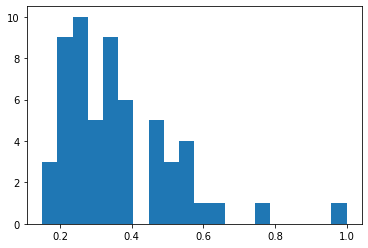

In [25]:
# plt.hist(p_wts[:1] + p_wts[1+1 :], bins=20);
plt.hist(p_wts, bins=20);

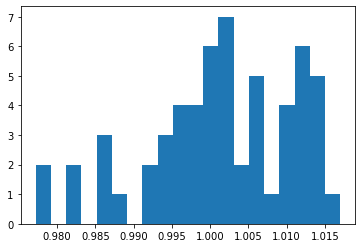

In [26]:
# plt.hist(personal_factor_w[:1] + personal_factor_w[1+1 :], bins=20);
plt.hist(personal_factor_w, bins=20);

<Figure size 576x432 with 0 Axes>

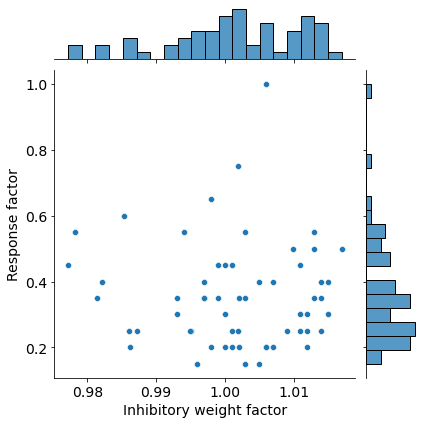

In [79]:

import seaborn as sns
# “scatter” | “kde” | “hist” | “hex” | “reg” | “resid” 

pers_params = pd.DataFrame({'Response factor': p_wts,'Inhibitory weight factor' : personal_factor_w})
fig = sns.jointplot(data=pers_params, x="Inhibitory weight factor", y="Response factor",  
              marginal_kws=dict(bins=20), kind='scatter');

fig.savefig('./figs_publ/param_distr_personalize.tiff', dpi=300, format="tiff", bbox_inches = "tight")

In [57]:
(p_cor, p_val) = stats.pearsonr(p_wts, personal_factor_w)
print(p_cor, p_val)
p_cor**2

-0.035049606919289336 0.7939387745366006


0.001228474945196695

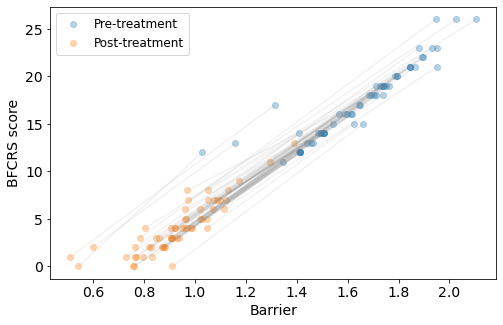

In [27]:
fig = plt.figure(figsize=(8,5))
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.plot(personalized_boundary['barrier_pre'], 
         personalized_boundary['pre_bf'], 'o', alpha=0.3, label='Pre-treatment')
plt.plot(personalized_boundary['barrier_post'], 
         personalized_boundary['post_bf'], 'o', alpha=0.3, label='Post-treatment')
for idx in personalized_boundary.index:
    plt.plot(personalized_boundary.loc[idx, ['barrier_pre','barrier_post']], 
             personalized_boundary.loc[idx, ['pre_bf','post_bf']], color='gray', alpha=0.1)
plt.xlabel('Barrier')
plt.ylabel('BFCRS score')
plt.legend();
# fig.savefig('./figs_publ/subjects_barrier_bf_personalize.tiff', dpi=300, format="tiff", bbox_inches = "tight")

17.993224606178753 -12.470912506475878 0.97994745837728


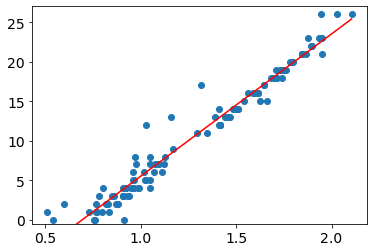

In [28]:
# Test linear fit for barrier-BF
x = personalized_boundary['barrier_pre'].append(personalized_boundary['barrier_post'])
y = personalized_boundary['pre_bf'].append(personalized_boundary['post_bf'])
gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print(gradient, intercept, r_value)
mn=np.min(x)
mx=np.max(x)
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
plt.plot(x,y,'o')
plt.plot(x1,y1,'-r')
plt.ylim(-0.5,27);

In [29]:
# x = personalized_boundary['barrier_pre'].append(personalized_boundary['barrier_post'])
# y = personalized_boundary['pre_bf'].append(personalized_boundary['post_bf'])
(p_cor, p_val) = stats.pearsonr(x,y)
print('Pearson correlation coefficient:', round(p_cor, 4))
print('Two-tailed p-value:', p_val)
(s_cor, p_val) = stats.spearmanr(x,y)
print('Spearman correlation coefficient:', round(s_cor, 4))
print('Two-tailed p-value:', p_val)

Pearson correlation coefficient: 0.9799
Two-tailed p-value: 1.0329850812217074e-81
Spearman correlation coefficient: 0.9811
Two-tailed p-value: 3.6301742316429954e-83


In [30]:
# personalized_boundary[(personalized_boundary['pre_bf']>15) 
#                       & (personalized_boundary['barrier_pre']<0.5)]
# personalized_boundary[(personalized_boundary['barrier_post']<0.6)]

In [31]:
def effect_size(pop1, pop2):
    stdev = np.sqrt(np.std(pop1)**2 + np.std(pop2)**2)
    effect_size = (np.mean(pop1) - np.mean(pop2))/stdev
    return effect_size

print ('Effect size', effect_size(personalized_boundary['barrier_pre'], personalized_boundary['barrier_post']))
f_val, p_val = stats.f_oneway(personalized_boundary['barrier_pre'], personalized_boundary['barrier_post'])  
print ('p-val:', p_val)

Effect size 2.6953125280366885
p-val: 9.410521606979223e-40


In [34]:
personalized_boundary['barrier_change'] = personalized_boundary['barrier_pre'] - personalized_boundary['barrier_post']
personalized_boundary['bf_change'] = personalized_boundary['pre_bf'] - personalized_boundary['post_bf']
personalized_boundary.describe()

,subj,param_wt,barrier_pre,barrier_post,pre_bf,post_bf,change_bf,target_barrier,personal_factor_w,barrier_change,bf_change
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,28.500000,0.357759,1.643722,0.929685,17.275862,4.086207,13.189655,0.659483,1.001598,0.714037,13.189655
std,16.886879,0.159990,0.215021,0.158679,3.919332,2.767509,3.337490,0.166874,0.009932,0.178441,3.337490
min,0.000000,0.150000,1.028840,0.509806,11.000000,0.000000,9.000000,0.450000,0.977228,0.476883,9.000000
25%,14.250000,0.250000,1.491640,0.835565,14.000000,2.000000,11.000000,0.550000,0.997000,0.589184,11.000000
50%,28.500000,0.350000,1.654781,0.927166,17.000000,4.000000,12.000000,0.600000,1.002000,0.648936,12.000000
75%,42.750000,0.450000,1.791937,1.026065,20.000000,6.000000,15.000000,0.750000,1.010748,0.809174,15.000000
max,57.000000,1.000000,2.104672,1.388834,26.000000,13.000000,23.000000,1.150000,1.017000,1.302031,23.000000


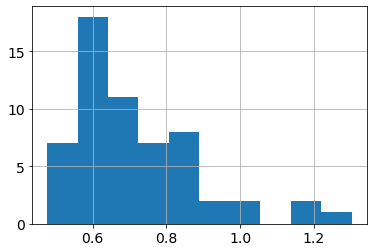

In [35]:
personalized_boundary['barrier_change'].hist();

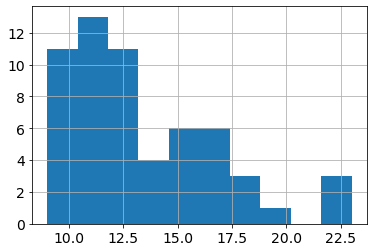

In [36]:
personalized_boundary['bf_change'].hist();

In [37]:
(p_cor, p_val) = stats.pearsonr(personalized_boundary['barrier_change'], personalized_boundary['bf_change'])
print(p_cor, p_val)
p_cor**2

0.9609505726810457 6.264181547622451e-33


0.9234260031360296

17.97322669296486 0.35610109207588003 0.9609505726810452


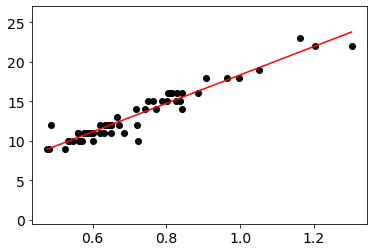

In [39]:
x = personalized_boundary['barrier_change']
y = personalized_boundary['bf_change']
gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print(gradient, intercept, r_value)
mn=np.min(x)
mx=np.max(x)
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
plt.plot(x,y,'ok')
plt.plot(x1,y1,'-r')
plt.ylim(-0.5,27);